In [2]:
import sys 
sys.path.append('/Users/dmitrys/anaconda2/lib/python2.7/site-packages')
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import warnings
warnings.filterwarnings(action="ignore")

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


Были взяты часовые данные (за несколько недель), о заходах пользователей в игрушку

In [3]:
DAU = pd.read_csv('/Users/dmitrys/Desktop/DAU_iOS.csv', index_col='Date')

In [4]:
DAU.columns = ['DAU']

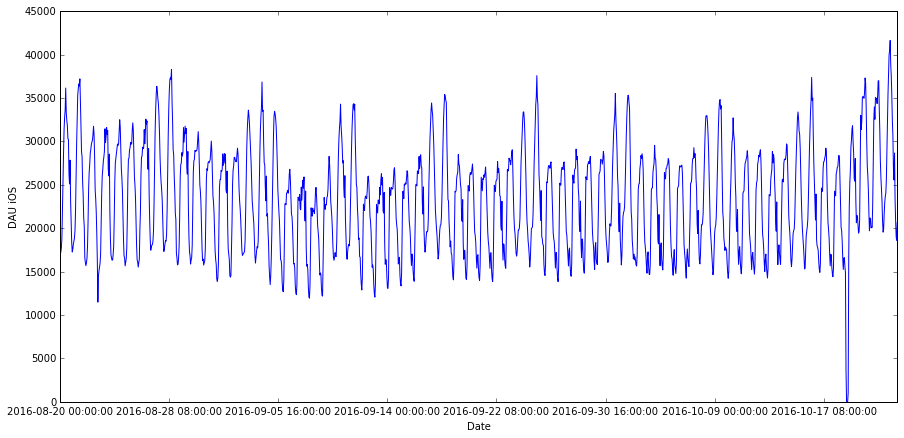

In [5]:
figsize(15,7) 
DAU.DAU.plot()
plt.ylabel('DAU iOS')
pylab.show()

1400 точка - момент выпуска обновления, после которого во временном ряду произошел структурный сдвиг, хотелось бы попробовать автоматически выявить подобную аномалию (в частности сам провал) 

In [144]:
DAU_train = DAU[:1400]
DAU_test = DAU[1400:]

Выделим тренд, сезонность и остатки в нашем временном ряду

Критерий Дики-Фуллера: p=0.024958


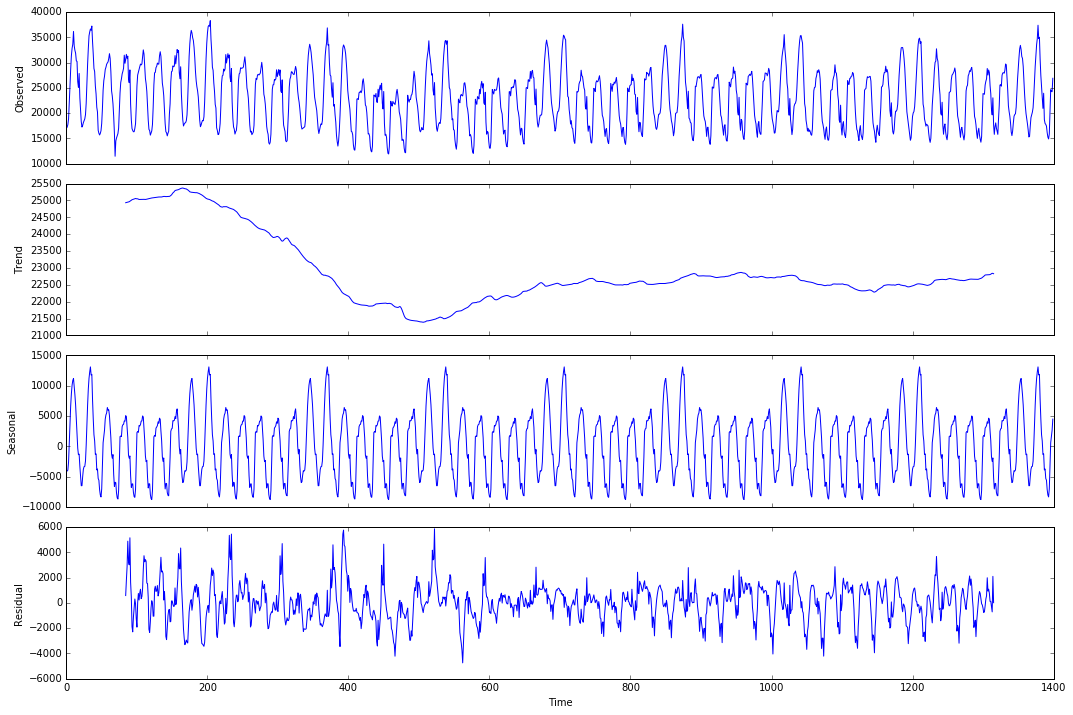

In [102]:
figsize(15,10)
res = sm.tsa.seasonal_decompose(DAU_train.DAU.values, freq=24*7) # так как есть и днейвная, и недельная цикличность
res.plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(DAU_train.DAU)[1])

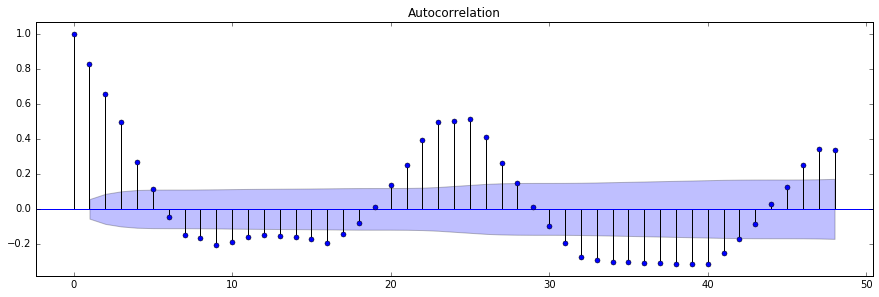

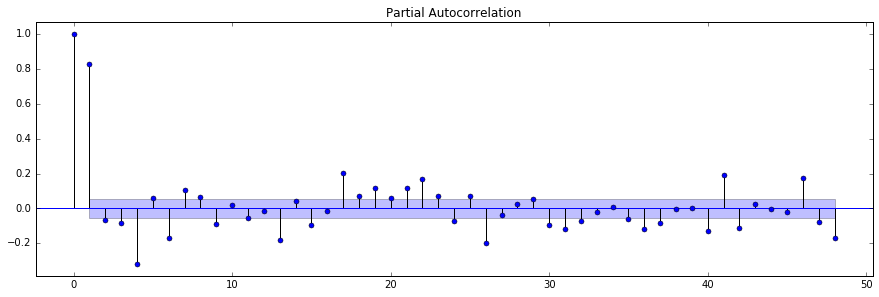

In [109]:
plot_acf_pacf(res.resid[12*7:-12*7])

Критерий Дикки-Фуллера настаивает на том, что наш ряд после таких процедур стал стационарным, что, конечно, хорошо, но вот ACF и PACF функции отказываются считать остатки случайными и видят в них автокоррелированность.

(Преобразования Бокса-Кокса оказались не нужны)

In [145]:
#DAU_train['iphone_box'], lmbda = stats.boxcox(DAU_train.DAU)
#figsize(15,7)
#DAU_train.iphone_box.plot()
#plt.ylabel(u'Transformed ios DAU')
#print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
#print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(DAU_train.iphone_box)[1])

In [146]:
#figsize(15,10)
#res = sm.tsa.seasonal_decompose(DAU_train.iphone_box.values, freq=24*7)
#res.plot()
#print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(DAU_train.iphone_box)[1])

Критерий Дики-Фуллера: p=0.002617


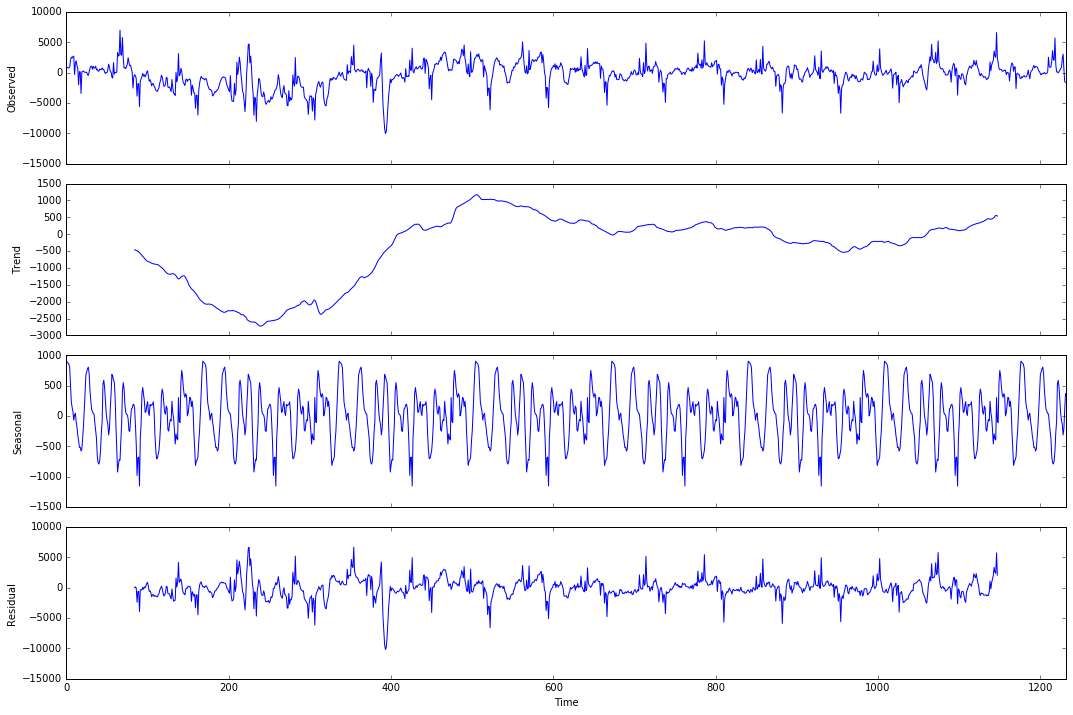

In [112]:
DAU_train['iphone_diff'] = DAU_train.DAU - DAU_train.DAU.shift(24*7)
res = sm.tsa.seasonal_decompose(DAU_train['iphone_diff'][24*7:].values, freq=24*7)
res.plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(DAU_train['iphone_diff'][24*7:])[1])

Неплохо, тепреь избавимся от тренда

Критерий Дики-Фуллера: p=0.000000


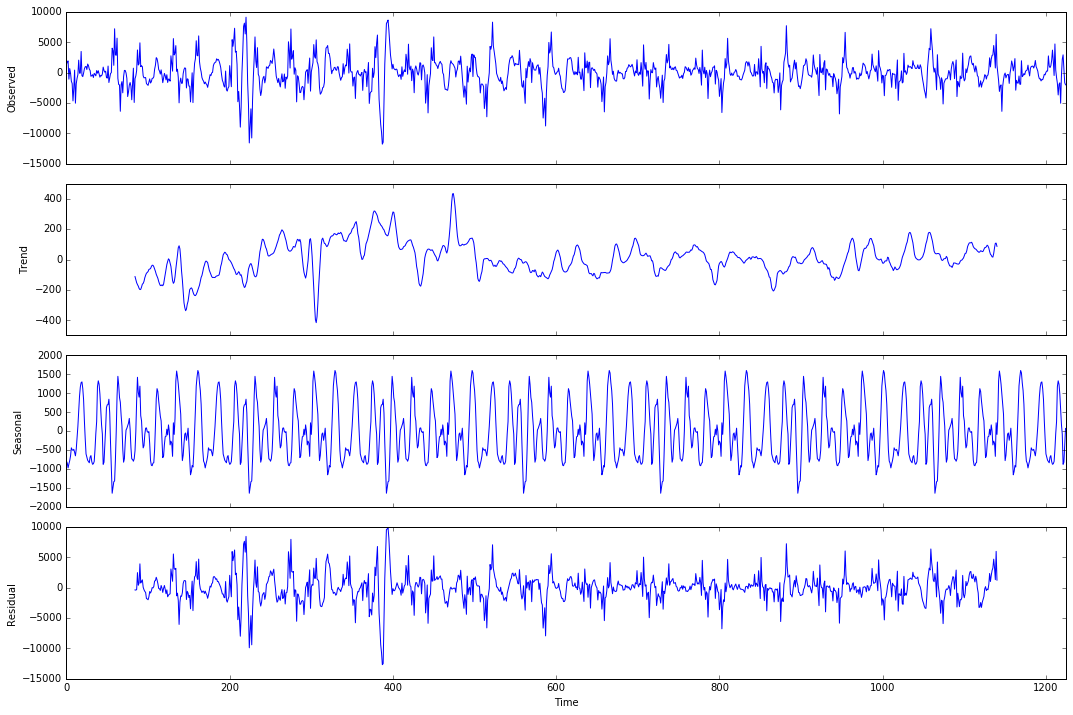

In [130]:
DAU_train['iphone_diff2'] = DAU_train.iphone_diff - DAU_train.iphone_diff.shift(7)
res = sm.tsa.seasonal_decompose(DAU_train['iphone_diff2'][24*7+7:].values, freq=24*7)
res.plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(DAU_train['iphone_diff2'][24*7+7:])[1])

Тренд, вроде, убрали, а графики всего этого дела теперь похожи на кардиограммы не очень здоровых людей

In [131]:
def plot_acf_pacf(data):
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(data.squeeze(), lags=48, ax=ax)
    pylab.show()
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(data.squeeze(), lags=48, ax=ax)
    pylab.show()

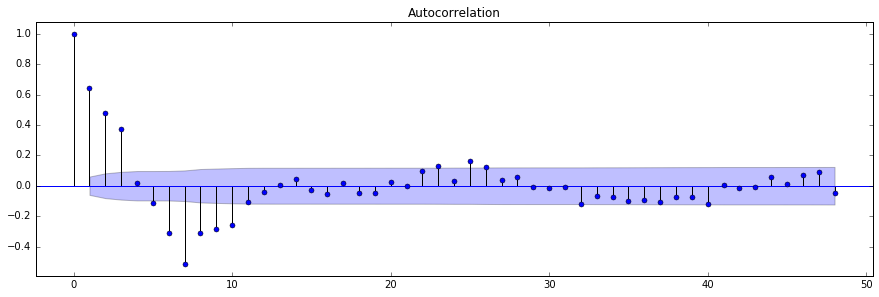

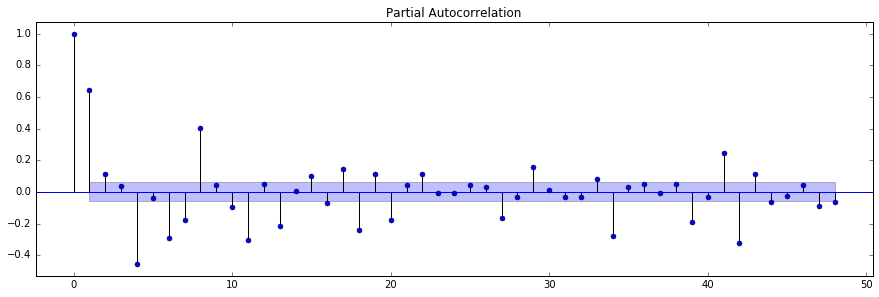

In [132]:
plot_acf_pacf(res.resid[12*7:-12*7])

In [133]:
ps = range(2, 4)
d=1
qs = range(0, 3)
Ps = range(0, 3)
D=1
Qs = range(1, 3)

In [134]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [135]:
#%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(DAU_train.iphone_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    

('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 0, 2))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 1, 1, 2))
('wrong parameters:', (2, 1, 2, 1))
('wrong parameters:', (2, 1, 2, 2))


In [136]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
27  (3, 2, 1, 2)  4958.778579
29  (3, 2, 2, 2)  4962.017558
9   (2, 2, 1, 2)  4963.530574
11  (2, 2, 2, 2)  4965.338245
21  (3, 1, 1, 2)  4975.936120


In [141]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         iphone_box   No. Observations:                 1400
Model:             SARIMAX(3, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -2470.389
Date:                            Fri, 06 Jan 2017   AIC                           4958.779
Time:                                    20:42:44   BIC                           5005.977
Sample:                                08-20-2016   HQIC                          4976.422
                                     - 10-17-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0208      0.031     -0.666      0.505      -0.082       0.040
ar.L2          0.6925      0.029   

Критерий Стьюдента: p=0.366327
Критерий Дики-Фуллера: p=0.000000


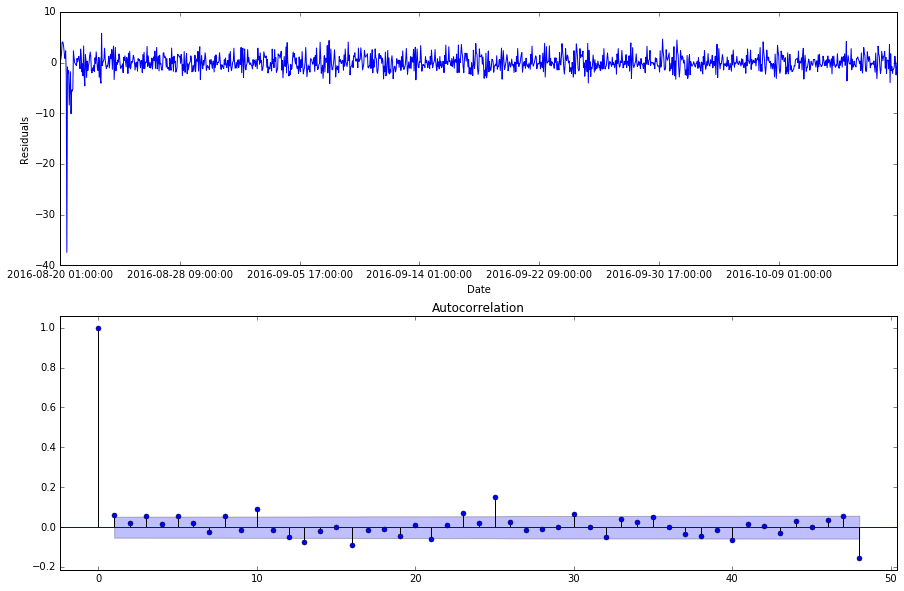

In [138]:
plt.subplot(211)
best_model.resid[1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[1:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

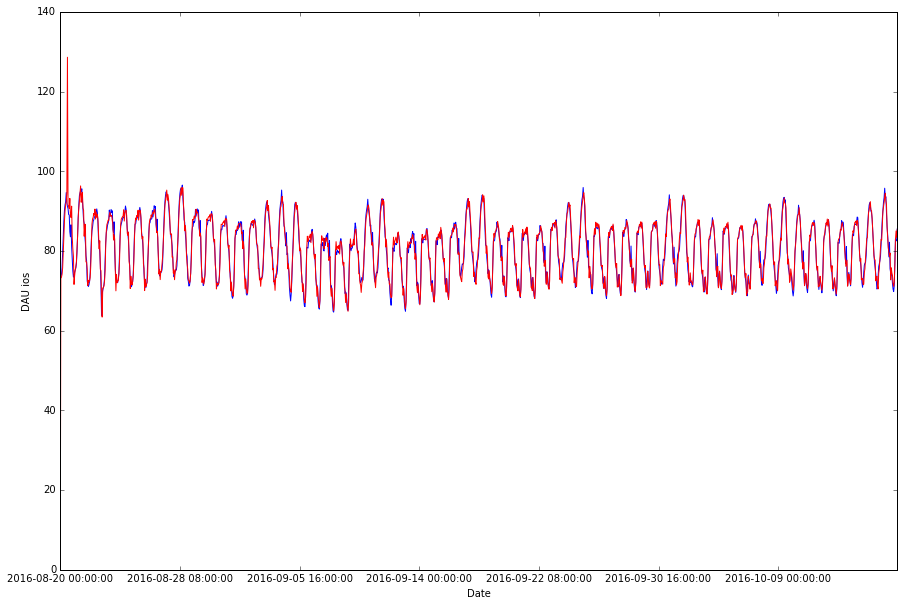

In [139]:
DAU_train['model'] = best_model.fittedvalues
DAU_train.iphone_box.plot()
DAU_train.model.plot(color='r')
plt.ylabel('DAU ios')
pylab.show()

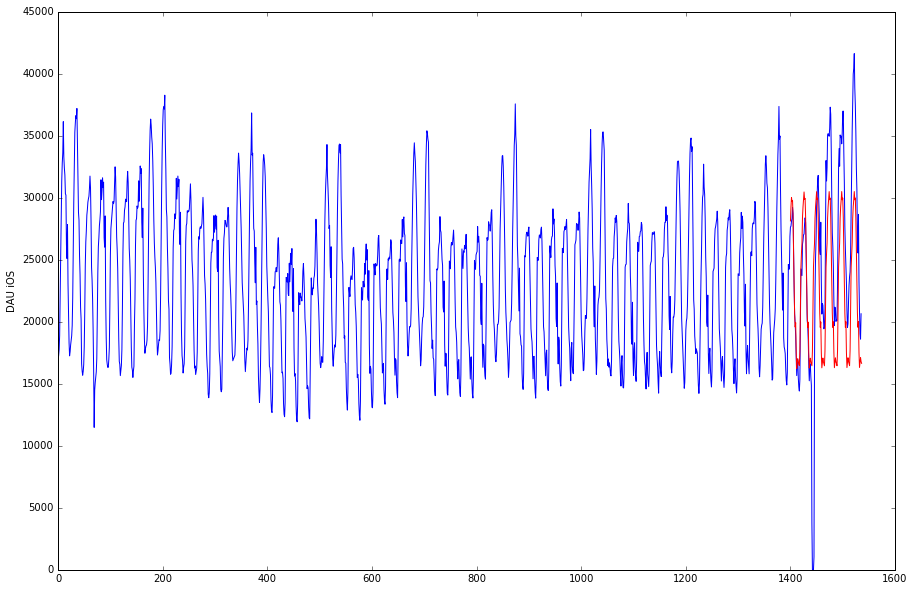

In [142]:
plt.plot(DAU.DAU.values)
l = [np.NaN] * len(DAU_train)

forecast = best_model.predict(start=len(DAU_train), end=len(DAU)).values


l.extend(invboxcox(forecast, lmbda))
plt.ylabel("DAU iOS")
plt.plot(l, color="r")

# Выводы

По большому счету, в контексте задачи о поиске аномалий можно было ограничиться первым выделением сезонности и тренда и спрогнозировать отдельно их, сезонность достаточно детерминированная, тренд также можно предсказать без особых проблем, а остатки либо не учитывать (так как разброс в +/- 3000 не так важен при абсолютных значениях в 30-40k, либо смоделировать ARCH-GARCH семейством.

К сожалению, ARIMA модели очень успешно и быстро сходятся к прогнозу по среднему в силу предположения о стационарности моделируемого процесса (в случае SARIMA модели, судя по графику, они сходятся к прогнозу выделенного цикла сезонности). Прогноз остатков более, чем на 1-3 шага в этом случае совсем не имеет смысла, так как авторегрессионная составляющая, в конечном итоге, будет опираться сама на себя, что и произошло с моим прогнозом.

Наконец, еще более логичным вариантом подхода конкретно для моей задачи поиска аномалии стало моделирование некоторого аналога VAR-кривой (обычно используется в финансах и риске для моделирования порогового значения, ниже или выше которого с заданной вероятностью не опустится наблюдаемый показатель). В этом случае было бы достаточно по GARCH модели прогнозировать первый-пятый перцентиль для распределения заходов игроков, и считать аномальными значения, пробивающие данный порог. 